# Analysis of TIC1707297_new Spectra

## Cleaning and Plotting data

In this step, we will plot all available data for the Star and also look at the Lomb Scargle Periodogram to identfy possible RV signals due to planets, companions stars or mag activity. Before this is done the blaze function is fitted to the original blaze uncorrected spectra. Please check if the provided targetname and spectra directory are correct.

In [1]:
star_name = 'TIC1707297_new'
directory_name = '/home/aaron/Desktop/ZASPE/Spectra/TIC170729755/'

In [2]:
from funcs import collect_fits_files
import numpy as np

#collect all fits files in the given directory
fits_files = collect_fits_files(directory_name)
    

### Plot the blaze corrected spectra

The the step takes long due to extensive plotting. The .png files are stored in Plots/star_name_observer_night.png. The star name is obtained from simbad. Default is Gliese catalog, if not available it will use Henry Draper and otherwise Tess Input. \ You do not have to run the next 2 cells as it takes long. However, if you are interested in how the spectra look, you might want to take a peak.

In [ ]:

from funcs import plot_arrays, query_tic_name,query_gliese_name,query_HD_name, extract_target_info, extract_target_info_astropy
import matplotlib.pyplot as plt
from astropy.io import fits 
from tqdm.notebook import tqdm
from time import sleep
import re

for i in tqdm(range(len(fits_files))): 
    spectrum = fits.getdata(fits_files[i])
    flux = spectrum[3,:] #CERES pipeline blaze corrected flux
    wavelength = spectrum[0,:]
    string = fits_files[i] 
    cut_string = string.split("/")[-1][:38] + ".png"
    
    target_name, observed_night = extract_target_info_astropy(fits_files[i])
    t1 = target_name 
    if target_name.startswith("GJ") == False:
        target_name = query_gliese_name(target_name)    #try to get gliese id
    if target_name == "Unknown":
        target_name = query_HD_name(t1)   #try to get HD id
    if target_name == "Unknown":
        target_name = query_tic_name(t1) # try to get TIC id
      
      
    #make sure there is no whitespaces in the target_name
    pattern = re.compile(r'\s+')
    target_name = re.sub(pattern, '', target_name)
    
    file_name = target_name + observed_night + ".png"
    save_dir = "Plots/" + target_name
    
    plot_arrays(flux,wavelength,save_dir=save_dir, save_filename=file_name)
    
    sleep(3)

In [ ]:

#example plot
#add the file you intend to show
example_file = save_dir + "/" + file_name
from IPython.display import display, Image
display(Image(filename=example_file))

In [9]:
from astropy.io import fits
fits.getheader(fits_files[0]) 

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 4096                                                  
NAXIS2  =                   70                                                  
NAXIS3  =                   11                                                  
EXTEND  =                    T                                                  
HIERARCH MJD =    59287.01218905261                                             
HIERARCH MBJD =    59287.01074486688                                            
HIERARCH SHUTTER START DATE = '2021031 '                                        
HIERARCH SHUTTER START UT = 0.1586111111111111                                  
HIERARCH TEXP (S) =             899.9965                                        
HIERARCH FLUX WEIGHTED MEAN 

### RV Analyis

In [3]:

from funcs import get_RV_BJD
#obtain RV, RV uncertainty and BJD from the CCFs 
rv, rv_err, bjd = get_RV_BJD(fits_files,ceres=True)

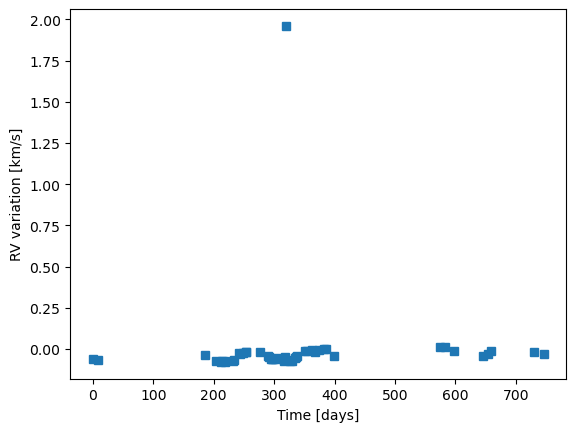

In [4]:

#plotting the RV variation
from funcs import plot_rvs

save_dir = 'Plots/' + star_name 
file_name = star_name + "_RV_variation.png"
plot_rvs(rv,rv_err/1000, bjd,save_dir, file_name,ms=False) 
#plt.ylim(-0.25,0.25)

In [5]:
#outlier removal
np.argmax(rv-np.mean(rv))
bjd = np.delete(bjd,36)
rv = np.delete(rv,36)
rv_err = np.delete(rv_err,36)

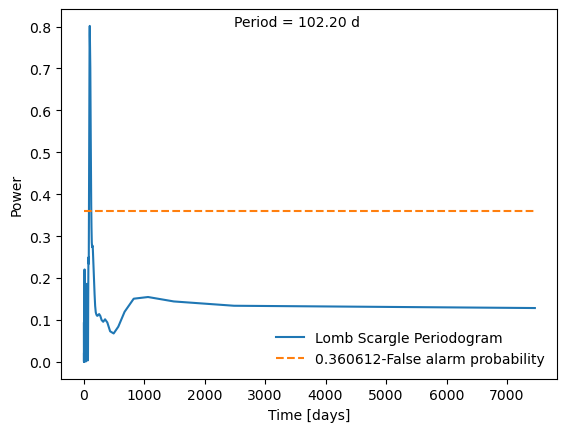

In [6]:

#plotting the LS Periodogram
from funcs import plot_lomb_scargle

file_name = star_name + "_Lomb_Scargle.png"
plot_lomb_scargle(bjd, rv, rv_err/1000, save_dir= save_dir, save_filename=file_name)

In [44]:
#nothing in exoplanet arxive.


## Combine and Align Spectra

In this step, we will combine and align all available spectra in the same time frame while removing artifacts that we dont want to have in the combined spectra, like saturation or cosmic rays. We will use two methods to combine the spectra - RV - correction method and Cross-Correlation Method.

### RV correction method

The RV correction is performed using the measured RVs by Harps. The wavelengths are then corrected for RV shift due to different time frames and moved to the first obervation night.

Night 32 in Order 0 has been discarded due to non-contributing flux.
Night 32 in Order 1 has been discarded due to non-contributing flux.
Night 32 in Order 2 has been discarded due to non-contributing flux.
Night 32 in Order 3 has been discarded due to non-contributing flux.
Night 32 in Order 4 has been discarded due to non-contributing flux.
Night 32 in Order 5 has been discarded due to non-contributing flux.
Night 32 in Order 6 has been discarded due to non-contributing flux.
Night 32 in Order 7 has been discarded due to non-contributing flux.
Night 32 in Order 8 has been discarded due to non-contributing flux.
Night 32 in Order 9 has been discarded due to non-contributing flux.
Night 32 in Order 10 has been discarded due to non-contributing flux.
Night 32 in Order 11 has been discarded due to non-contributing flux.
Night 32 in Order 12 has been discarded due to non-contributing flux.
Night 32 in Order 13 has been discarded due to non-contributing flux.
Night 32 in Order 14 has been 

<IPython.core.display.Javascript object>


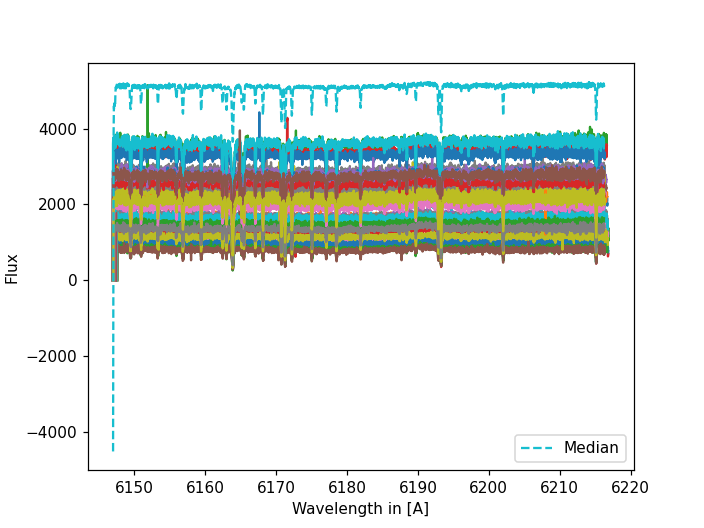

In [3]:
  
import scipy.constants as c

c_km = c.c/1000 
    
    
%matplotlib notebook
from funcs import plot_fluxes, plot_median_spectrum, interpolate_flux, get_wavelength_flux_RV, save_spectrum_as_text 

#get fit files
filelist = fits_files

#get observed wavelength, flux and eflux; extract RV and calculate corrected wavelength
wave, flux, eflux, RV, BERV, wave_corr, combined_orders = get_wavelength_flux_RV(filelist, ceres = True)

#BERV = 0 for ceres because already corrected for

#get reference wavelength from first observation night 
wave_ref_corr = wave[0] / (1 + RV[0] / c_km) 

#interpolate flux at corrected wavelength and on the corrected wavelegnths reference
flux_interp = interpolate_flux(wave, flux, wave_ref_corr, RV, BERV)

#median flux for specific order
flux_median = np.median(flux_interp, axis=0)

#controll plots for specific order
norder = 10 
plot_fluxes(wave_corr, flux, norder) 
plot_median_spectrum(wave_ref_corr, flux_median+3000, norder)   

#save the spectrum as txt file for ZASPE
save_directory = "Spectra/" + star_name 
file_name = star_name + "_RV_method.txt"
save_spectrum_as_text(combined_orders, wave_ref_corr, flux_median, save_directory, file_name)
    

### Cross-correlation method

The cross-correlation method takes the median flux from the RV method as star templat to correlate with. It then performes combines and alignes the spectra via cross correlation to the reference template. At the moment there are some issus with the cc method why using only RV method is recommended. In principle should the RV method result in the most accurate shift to the assigned reference spectrum.

In [8]:
    
from funcs import align_spectra
from funcs import combine_spectra
from astropy.io import fits 
import matplotlib.pyplot as plt

num_orders = np.shape(fits.getdata(fits_files[0]))[1]

#template is the RV corrected version
template = flux_median 

#Specify the spectral order to combine
combined_spectra = []
for i in range(num_orders):
    combined_spectrum = combine_spectra(fits_files, i, template,blaze_corrected=True)
    combined_spectra.append(np.array(combined_spectrum))

combined_spectra = np.array(combined_spectra)


Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/TIC170729755/TIC170729775_2022-01-12T05:51:00.380sp.fits in order 0 has been discarded due to significant deviation. Median value 90.0444853771538
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/TIC170729755/TIC170729775_2022-01-12T05:51:00.380sp.fits in order 1 has been discarded due to significant deviation. Median value 97.73605643929176
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/TIC170729755/TIC170729775_2022-01-12T05:51:00.380sp.fits in order 2 has been discarded due to significant deviation. Median value 100.11643067196502
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/TIC170729755/TIC170729775_2022-01-12T05:51:00.380sp.fits in order 3 has been discarded due to significant deviation. Median value 102.19837066230012
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/TIC170729755/TIC170729775_2022-01-12T05:51:00.380sp.fits in order 4 has been discarded due to significant deviation. Median value 99.4187

Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/TIC170729755/TIC170729775_2022-01-12T05:51:00.380sp.fits in order 41 has been discarded due to significant deviation. Median value 44.30533948767935
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/TIC170729755/TIC170729775_2022-01-12T05:51:00.380sp.fits in order 42 has been discarded due to significant deviation. Median value 42.688411069315435
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/TIC170729755/TIC170729775_2022-01-12T05:51:00.380sp.fits in order 43 has been discarded due to significant deviation. Median value 39.69477497508416
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/TIC170729755/TIC170729775_2022-01-12T05:51:00.380sp.fits in order 44 has been discarded due to significant deviation. Median value 36.524689798526225
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/TIC170729755/TIC170729775_2022-01-12T05:51:00.380sp.fits in order 45 has been discarded due to significant deviation. Median value 3

<IPython.core.display.Javascript object>


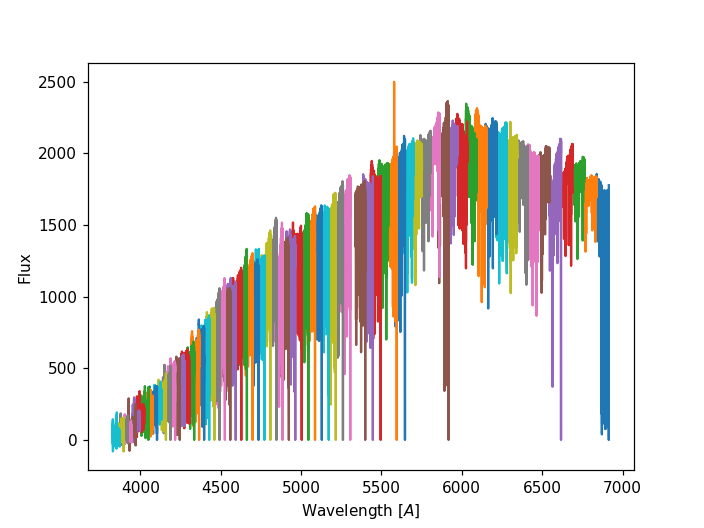

In [9]:


%matplotlib notebook 

import matplotlib.pyplot as plt 
plt.xlabel(r"Wavelength $[A]$")
plt.ylabel(r"Flux")
for i in range(len(combined_spectra[:,1])):
    plt.plot(combined_spectra[:,1][i], combined_spectra[:,2][i])



In [10]:

    
from funcs import store_spectrum_orders
save_dir = "Spectra/" + star_name + "/"

#Cross correlation method    
file_name = star_name + "_CCM" + ".txt"

store_spectrum_orders(combined_spectra[:,1],combined_spectra[:,2], save_dir = save_dir, file_name = file_name )

The spectrum for all orders has been stored in the file: Spectra/TIC1707297_new/TIC1707297_new_CCM.txt
